# EOA - Semestral task #
# Warehouse allocation #
Filip Špidla

spidlfil@fel.cvut.cz

## Problem Description

A company serves a group of geographically distributed customers, each demanding a certain amount of goods. To cover all the customers efficiently, the company decides to build a network of warehouses at various locations, each with its own capacity.

**The goal** is to assign customers to warehouses in the most efficient way possible.

### Input:

- **N warehouses**, each warehouse $w$ has:
  - a capacity $cap_w$
  - a set-up cost $s_w$
- **M customers**, each customer $c$ demands a certain amount of goods $d_c$
- For each pair $(c, w)$, a cost $t_{cw}$ for delivering the goods from warehouse $w$ to customer $c$ is defined.

### Output:

The task is to assign customers to warehouses such that the following uniform evaluation function is minimized:

$$
f(x) = \sum_{w \in N} \left( I(\left| a_w \right| > 0) \cdot s_w + \sum_{c \in a_w} t_{cw} \right)
$$

subject to:

$$
\sum_{c \in a_w} d_c \leq cap_w,
$$

$$
\sum_{w \in N} I(c \in a_w) = 1 \quad \forall c \in M,
$$

where $a_w$ is the set of customers assigned to warehouse $w$ and $I(\cdot)$ is an indicator function (returns 1 if the argument is true, 0 otherwise).


### topic shall be solved with ###

1) a local search algorithm,
2) simple evolutionary algorithm and
3) a specialized EA or memetic algorithm (EA combined with local search).

# Implementation: 

In [37]:
import random
import time


# Reading the input file
def read_input_file(file_path):
    with open(file_path, 'r') as file:
        N, M = map(int, file.readline().split())
        warehouses = [list(map(float, file.readline().split())) for _ in range(N)]
        customers = [(float(file.readline()), list(map(float, file.readline().split()))) for _ in range(M)]
    return N, M, warehouses, customers

# Generate initial solution
def initial_solution(N, M, warehouses, customers):
    solution = []
    for c in range(M):
        available_warehouses = [w for w in range(N) if warehouses[w][0] >= customers[c][0]]
        assigned_warehouse = random.choice(available_warehouses)
        solution.append(assigned_warehouse)
    return solution

# Calculate cost of a solution
def calculate_cost(solution, warehouses, customers):
    total_cost = 0
    warehouse_used = [False] * len(warehouses)
    for c, w in enumerate(solution):
        total_cost += customers[c][1][w]
        warehouse_used[w] = True
    total_cost += sum(warehouses[w][1] for w, used in enumerate(warehouse_used) if used)
    return total_cost

# Local Search Algorithm
def ls1(N, M, warehouses, customers, initial_sol, t_end):
    current_sol = initial_sol
    current_cost = calculate_cost(current_sol, warehouses, customers)
    improved = True

    while improved:
        improved = False
        for c in range(M):
            for w in range(N):

                if(time.time() > t_end):
                    return current_sol
        
                if w != current_sol[c]:
                    new_sol = current_sol.copy()
                    new_sol[c] = w
                    new_cost = calculate_cost(new_sol, warehouses, customers)
                    if new_cost < current_cost:
                        current_sol = new_sol
                        current_cost = new_cost
                        improved = True
                        break
            if improved:
                break

    #print(current_sol)
    return current_sol

def ls2(N, M, warehouses, customers, initial_sol, t_end):
    current_sol = initial_sol
    current_cost = calculate_cost(current_sol, warehouses, customers)
    
    # Iterate over each customer
    for c in range(M):
        for w in range(N):

            if(time.time() > t_end):
                return current_sol
            
            # Check if assigning the customer to this warehouse improves the cost
            if w != current_sol[c]:
                new_sol = current_sol.copy()
                new_sol[c] = w
                new_cost = calculate_cost(new_sol, warehouses, customers)
                
                # If cost is improved, accept this assignment and move to the next customer
                if new_cost < current_cost:
                    current_sol = new_sol
                    current_cost = new_cost
                    break  # Break out of the warehouse loop, move to next customer

    return current_sol


# Tournament Selection
def tournament_selection(population, k, warehouses, customers):
    selected = random.sample(population, k)
    selected.sort(key=lambda sol: calculate_cost(sol, warehouses, customers))
    return selected[:2]

# One-point Crossover
def crossover(parent1, parent2):
    point = random.randint(1, len(parent1) - 1)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

# Mutation
def mutation(solution, N):
    c = random.randint(0, len(solution) - 1)
    w = random.randint(0, N - 1)
    solution[c] = w
    return solution

# Memetic Algorithm (MA)
def memetic_algorithm(N, M, warehouses, customers, pop_size, generations, local_search=None, ls_interval=5, max_time = 10):
    population = [initial_solution(N, M, warehouses, customers) for _ in range(pop_size)]
    best_cost_per_generation = []

    t_end = time.time() + max_time

    gen = 0
    while time.time() < t_end:
        gen+=1
    #for gen in range(generations):
        fitness = [calculate_cost(sol, warehouses, customers) for sol in population]
        
        # Track best cost
        best_cost = min(fitness)
        best_cost_per_generation.append(best_cost)

        parents = [tournament_selection(population, 2, warehouses, customers) for _ in range(pop_size)]

        offspring = []
        for _ in range(pop_size // 2):  # Ensure we generate enough offspring
            parent1, parent2 = tournament_selection(population, 4, warehouses, customers)  # Select 4 and pick best 2
            child1, child2 = crossover(parent1, parent2)
            offspring.append(mutation(child1, N))
            offspring.append(mutation(child2, N))

        if local_search and gen % ls_interval == 0:
            for i in range(len(offspring)):
                if(time.time() > t_end):
                    break
                offspring[i] = local_search(N, M, warehouses, customers, offspring[i], t_end)

        population = offspring[:pop_size]

    best_sol = min(population, key=lambda sol: calculate_cost(sol, warehouses, customers))
    best_cost = calculate_cost(best_sol, warehouses, customers)
    return best_sol, best_cost, best_cost_per_generation

## Local Search Strategies

In my implementation, I utilize two Local Search strategies - LS1 and LS2, to provide possible solution for Warehouse allocation problem and enhance the performance of the Genetic Algorithm

- **LS1 Method**: This strategy iteratively improves the solution by exploring the neighborhood of the current solution. For each customer, the algorithm tries reassigning them to different warehouses and calculates the cost. If a reassignment leads to a lower total cost, it is accepted as the new current solution. This process continues until no further improvements can be made. LS1 is comprehensive but can be time-consuming, especially for larger problems.

- **LS2 Method**: The LS2 strategy is a more streamlined version of LS1. It goes through each customer exactly once, attempting to reassign them to a different warehouse. If the reassignment results in a cost reduction, it is immediately accepted, and the algorithm moves to the next customer. This approach is faster than LS1 as it makes a single pass over all customers, making it more efficient for larger datasets.

Both methods can be integrated into the Genetic Algorithm framework to find more optimal solutions to the Warehouse Allocation Problem, with the theory being that LS1 is more precise in finding optimal solution given existing solution, and  LS2 being useful for larger problem instances due to its lower time complexity, allowing for greater margin of optimization by GA part of algorithm.


## Genetic Algorithm overview

The GA starts by generating an initial population of solutions, where each solution represents a potential warehouse allocation for customers. Key operations of the GA include tournament selection, one-point crossover, and mutation.

- **Tournament Selection**: This method selects the best solutions from a randomly chosen subset of the population, ensuring that higher-quality solutions have a higher chance of being chosen for breeding.

- **One-point Crossover**: This crossover method combines two parent solutions to produce offspring. It randomly selects a crossover point and exchanges the subsequences of the parents' solutions after this point.

- **Mutation**: Mutation introduces randomness by randomly altering a part of a solution. In this case, it randomly changes the warehouse assignment for a customer, helping to maintain genetic diversity in the population.


## Memetic Algorithm overview

- **Integration of Local Search**: The key feature of our MA is the periodic incorporation of Local Search methods (LS1 or LS2). After certain genetic operations, each solution in the population undergoes a local search. This step refines solutions by exploring their neighborhood, potentially leading to lower-cost allocations.

- **Adaptive Process**: The MA adapts its search strategy according to the problem's demands. It combines the explorative power of Genetic Algorithms with the optimization of Local Search, effectively tackling the Warehouse Allocation Problem's complexity.

In [38]:
import matplotlib.pyplot as plt
def run_and_plot_iterations(N, M, warehouses, customers, iterations, pop_size, generations, local_search=None, ls_interval=5, max_time = 10):
    all_best_costs = []

    sum = 0

    for _ in range(iterations):
        a, b, best_costs = memetic_algorithm(N, M, warehouses, customers, pop_size, generations, local_search, ls_interval, max_time)
        sum = sum + b
        all_best_costs.append(best_costs)

    print(f"average cost found: {sum/iterations}")

    # Plotting
    plt.figure(figsize=(10, 6))
    for i, costs in enumerate(all_best_costs):
        plt.plot(costs, label=f'Run {i + 1}')

    plt.title('Improvement of Solution Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Best Cost')
    plt.legend()
    plt.show()

    return sum/iterations


In [39]:
#
def run_and_plot_searches(N, M, warehouses, customers, iterations, pop_size, generations, local_search=ls1, ls_interval=5, max_time = 2):

    all_best_costs = []
    sum = 0

    for i in range(iterations):
        t_end = time.time() + max_time
        best = 0
        all_best_costs_curr = []

        gen = 0
        while(time.time() < t_end):
            gen+=1
            initial_sol = initial_solution(N, M, warehouses, customers)
            a = local_search(N, M, warehouses, customers, initial_sol, t_end)
            b = calculate_cost(a, warehouses, customers)
            if(gen==1):
                best = b
            if(b < best):
                best = b	
                all_best_costs_curr.append([best,gen])

        all_best_costs_curr.append([best,gen])

        sum = sum + best
        all_best_costs.append(all_best_costs_curr)

    print(f"average cost found: {sum/iterations}")

    plt.figure(figsize=(10, 6))
    #for i, costs in enumerate(all_best_costs):
    #    plt.plot(costs, label=f'Run {i + 1}')

    for i, costs in enumerate(all_best_costs):
        x = []
        y = []
        for j, cost in enumerate(costs):
            x.append(cost[1])
            y.append(cost[0])
        plt.plot(x, y, label=f'Run {i + 1}')

    plt.title('Improvement of Solution Over Iterations')
    plt.xlabel('Generation')
    plt.ylabel('Best Cost')
    plt.legend()
    plt.show()




    return best




In [40]:

def testWarehouse(file_name, iterations, pop_size, generations, ls_interval, max_time):
    N, M, warehouses, customers = read_input_file(file_name)
    print(f"File: {file_name}")
    print(f"Population size: {pop_size}")
    print(f"Generations: {generations}")
    print(f"Local Search Interval: {ls_interval}")
    print(f"Max Time: {max_time}")

    print("LS1 Search")
    ls1_search_avg = run_and_plot_searches(N, M, warehouses, customers, iterations, pop_size, generations, local_search=ls1, ls_interval=ls_interval, max_time = max_time)

    print("LS2 Search")
    ls2_search_avg = run_and_plot_searches(N, M, warehouses, customers, iterations, pop_size, generations, local_search=ls2, ls_interval=ls_interval, max_time = max_time)

    print("GA")
    none_avg = run_and_plot_iterations(N, M, warehouses, customers, iterations, pop_size*2, generations, local_search=None, ls_interval=ls_interval, max_time = max_time)

    print("Memetic algorithm with LS1")
    ls1_avg = run_and_plot_iterations(N, M, warehouses, customers, iterations, pop_size, generations, local_search=ls1, ls_interval=ls_interval, max_time = max_time)

    print("Memetic algorithm with LS2")
    ls2_avg = run_and_plot_iterations(N, M, warehouses, customers, iterations, pop_size, generations, local_search=ls2, ls_interval=ls_interval, max_time = max_time)

    #print("None Search")
    #none_search_avg = run_and_plot_searches(N, M, warehouses, customers, iterations, pop_size, generations, local_search=None, ls_interval=ls_interval, max_time = max_time)

    print(f"LS1 Search Average: {ls1_search_avg}")
    print(f"LS2 Search Average: {ls2_search_avg}")
    print(f"GA Average: {none_avg}")
    print(f"MA with LS2 Average: {ls1_avg}")
    print(f"MA with LS2 Average: {ls2_avg}")



# Experimentation

I will conducta series of experiments to evaluate different implemented strategies for solving the Warehouse Allocation Problem. 

- **Experimental Setup**: For each problem instance, I will run experiments using LS1, LS2, and no local search with the Genetic Algorithm. The `testWarehouse` function configures the parameters such as population size, number of generations, local search interval, and maximum time allowed for each run.

- **Evaluation Criteria**: I assess the average performance of each strategy across multiple iterations. This involved running and plotting the results for each approach, including pure GA, GA with LS1, and GA with LS2. The effectiveness is then assessed based on average cost obtained over runs of the algorithms' setups.

- **Comparative Analysis**: By measuring the average costs and behaviors of LS1, LS2, GA, GA with LS1, and GA with LS2, I aim to identify which approach generally yields the most cost-effective solutions for the Warehouse Allocation Problem

### Experimental Setup Parameters

- **File Name**: The experiments are conducted on warehouse allocation problem instances, specified by `file_name`, such as "warehouses\wl_16_1".
- **Population Size (`pop_size`)**: 50, determining the number of solutions in each generation of the Genetic Algorithm.
- **Number of Generations (`generations`)**: 20, defining how many times the population will evolve through genetic operations. Currently does not influence algorithm in any way
- **Local Search Interval (`ls_interval`)**: 5, indicating how frequently Local Search (LS1 or LS2) is applied in the Memetic Algorithm.
- **Maximum Time (`max_time`)**: 10 seconds, setting the time limit for each run of the algorithm.
- **Iterations**: Each strategy (GA, GA with LS1, GA with LS2) is tested for 5 iterations to obtain an average performance.

# Leo's warehouses

I shall begin with same tests as done by my colleague

File: warehouses\wl_16_1
Population size: 50
Generations: 20
Local Search Interval: 5
Max Time: 10
LS1 Search
average cost found: 933568.9


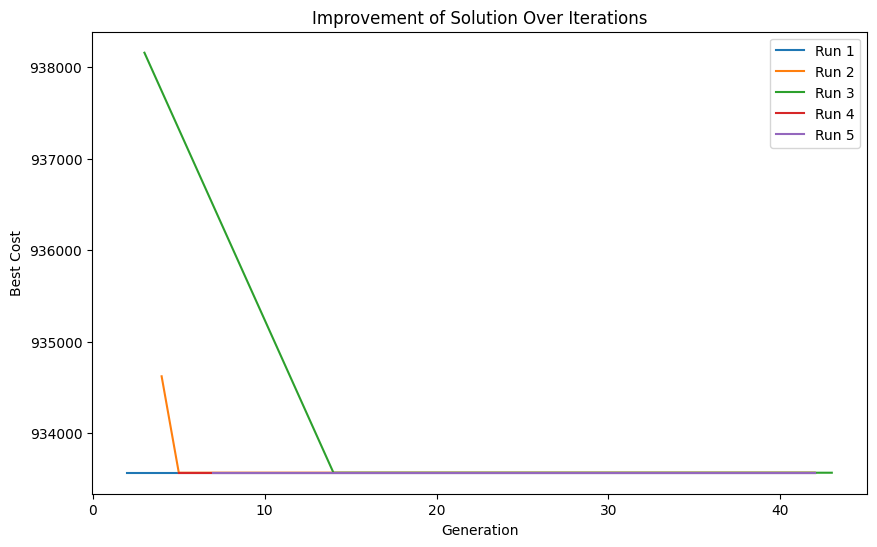

LS2 Search
average cost found: 1118402.7450000003


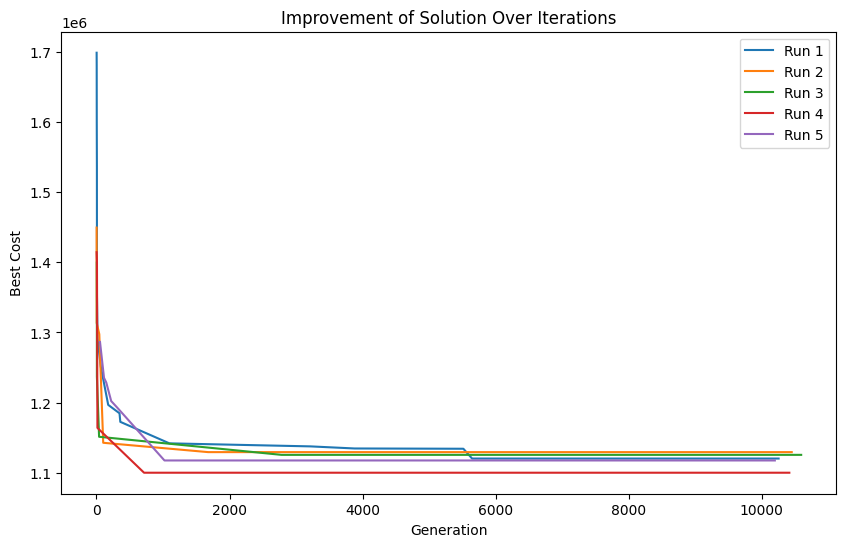

GA
average cost found: 969756.8825


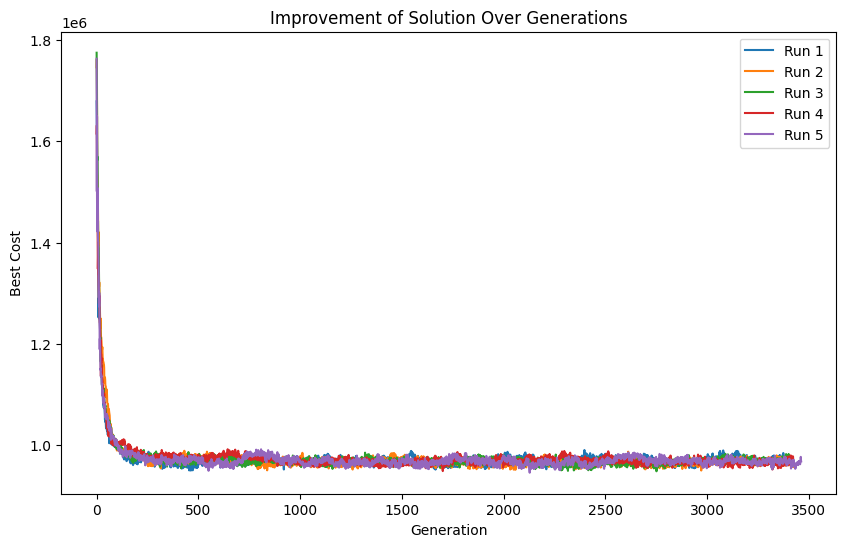

Memetic algorithm with LS1
average cost found: 934548.2224999999


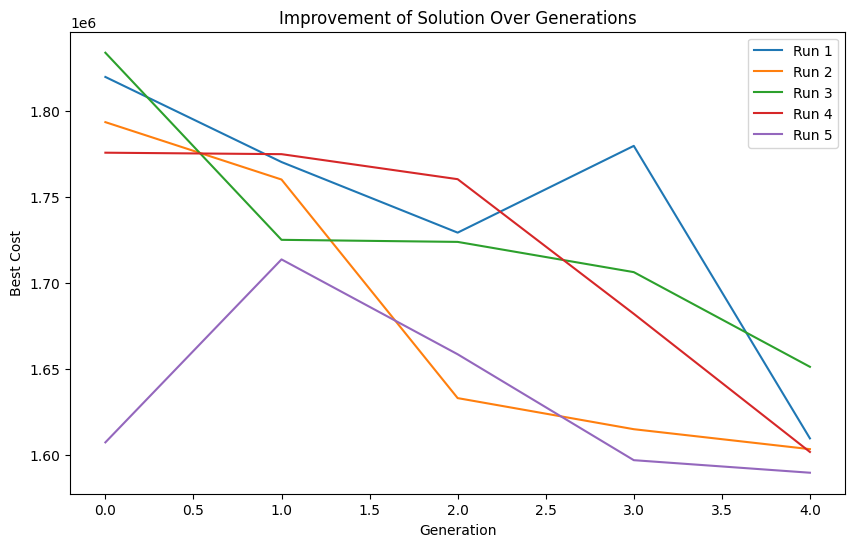

Memetic algorithm with LS2
average cost found: 939130.8524999998


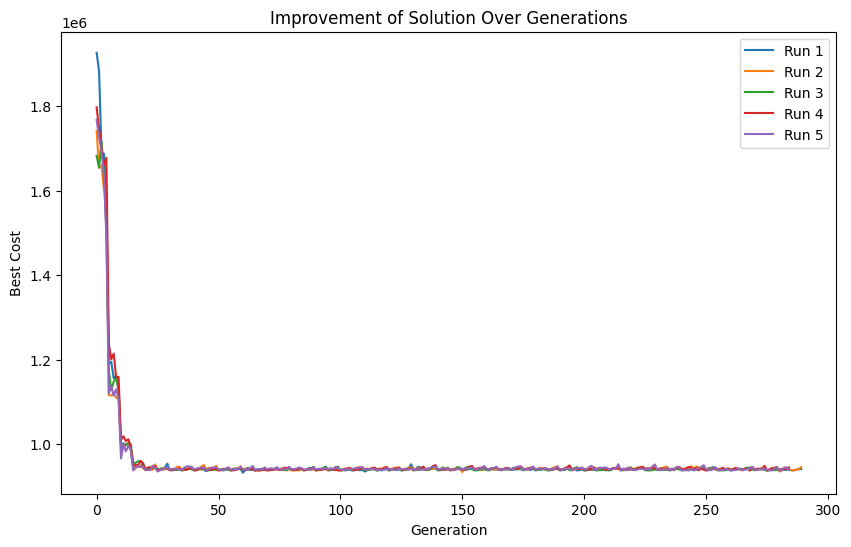

LS1 Search Average: 933568.8999999999
LS2 Search Average: 1117368.9250000003
GA Average: 969756.8825
MA with LS2 Average: 934548.2224999999
MA with LS2 Average: 939130.8524999998


In [41]:
testWarehouse("warehouses\wl_16_1", 5, 50, 20, 5, 10)

File: warehouses\wl_25_2
Population size: 50
Generations: 20
Local Search Interval: 5
Max Time: 10
LS1 Search
average cost found: 800131.99


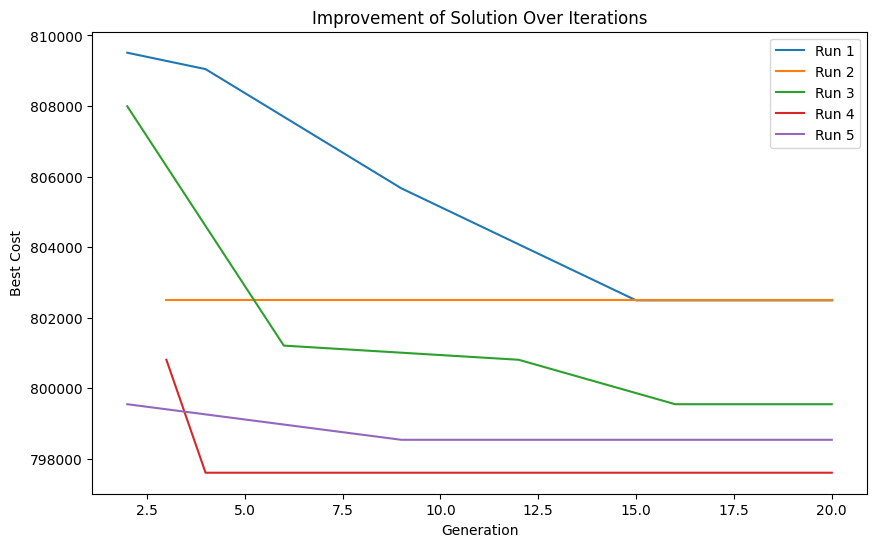

LS2 Search
average cost found: 1061865.5400000003


GA
average cost found: 853634.2100000002


Memetic algorithm with LS1
average cost found: 801491.79


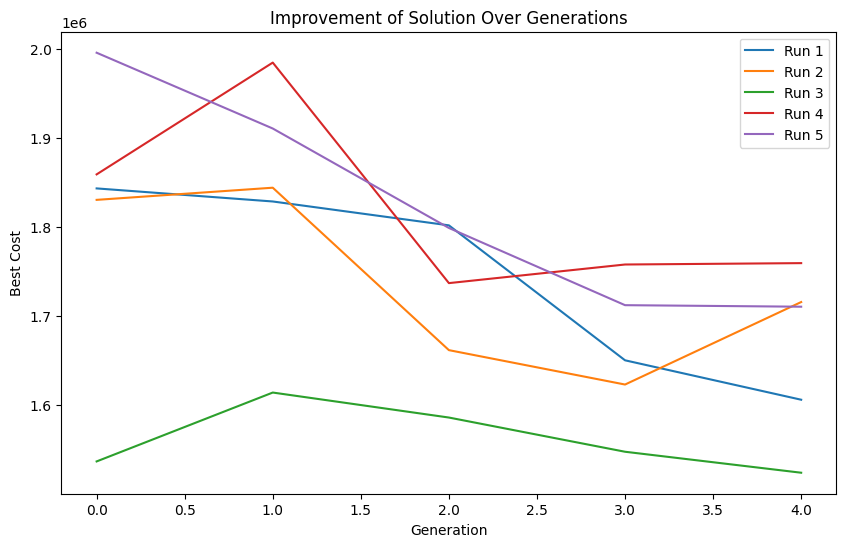

Memetic algorithm with LS2
average cost found: 803482.705


LS1 Search Average: 798535.4375
LS2 Search Average: 1063601.6125000003
GA Average: 853634.2100000002
MA with LS2 Average: 801491.79
MA with LS2 Average: 803482.705


In [42]:
testWarehouse("warehouses\wl_25_2", 5, 50, 20, 5, 10)

File: warehouses\wl_200_1
Population size: 50
Generations: 20
Local Search Interval: 5
Max Time: 10
LS1 Search
average cost found: 40392.170340000004


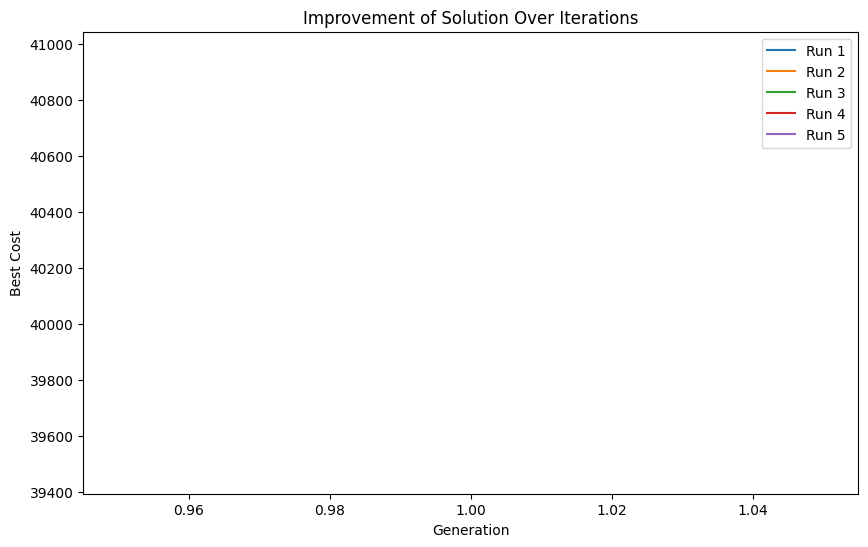

LS2 Search
average cost found: 5876.222744000001


GA
average cost found: 14223.46971


Memetic algorithm with LS1
average cost found: 38985.32685200001


Memetic algorithm with LS2
average cost found: 6136.901748


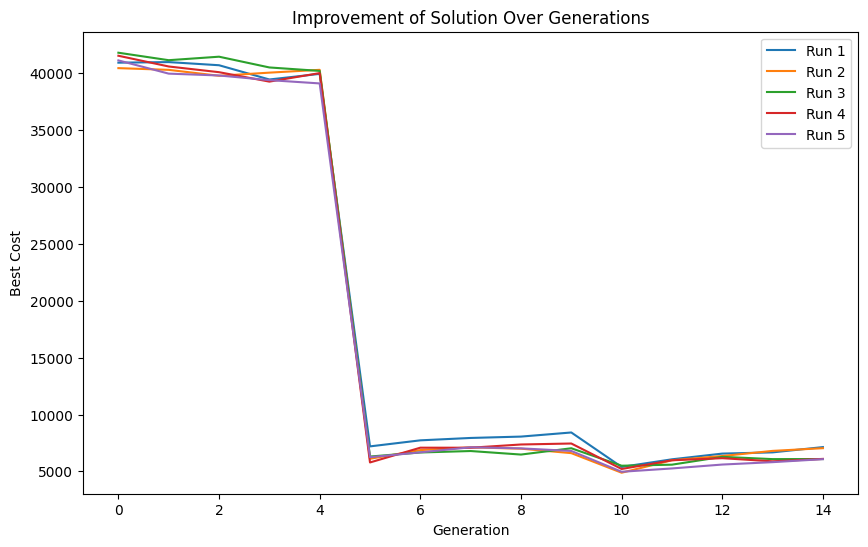

LS1 Search Average: 40325.23686000001
LS2 Search Average: 6030.561530000001
GA Average: 14223.46971
MA with LS2 Average: 38985.32685200001
MA with LS2 Average: 6136.901748


In [43]:
testWarehouse("warehouses\wl_200_1", 5, 50, 20, 5, 10)

# Additional tests

File: warehouses\wl_50_1
Population size: 50
Generations: 20
Local Search Interval: 5
Max Time: 10
LS1 Search
average cost found: 823367.775


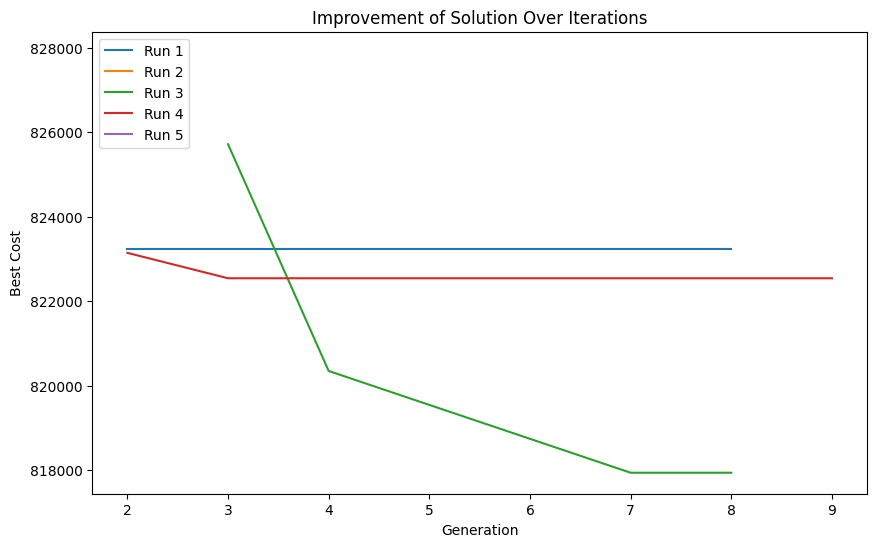

LS2 Search
average cost found: 1219669.1300000001


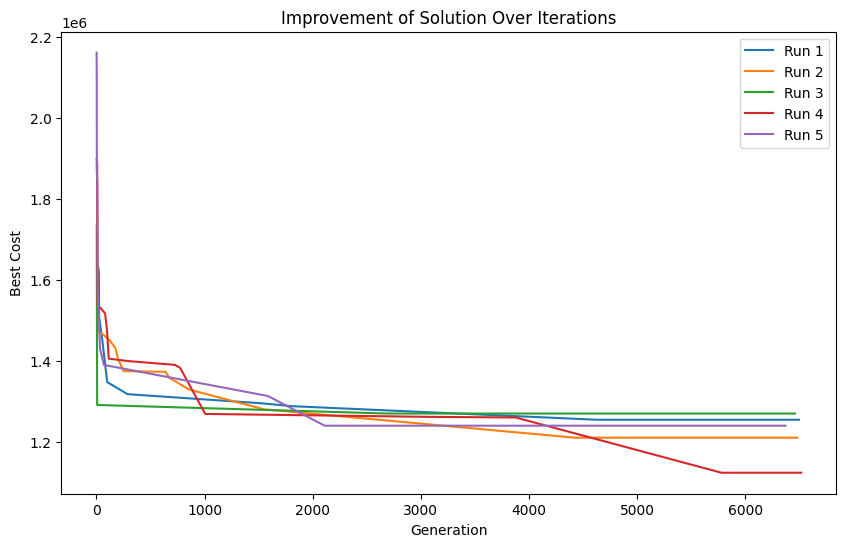

GA
average cost found: 888831.2700000001


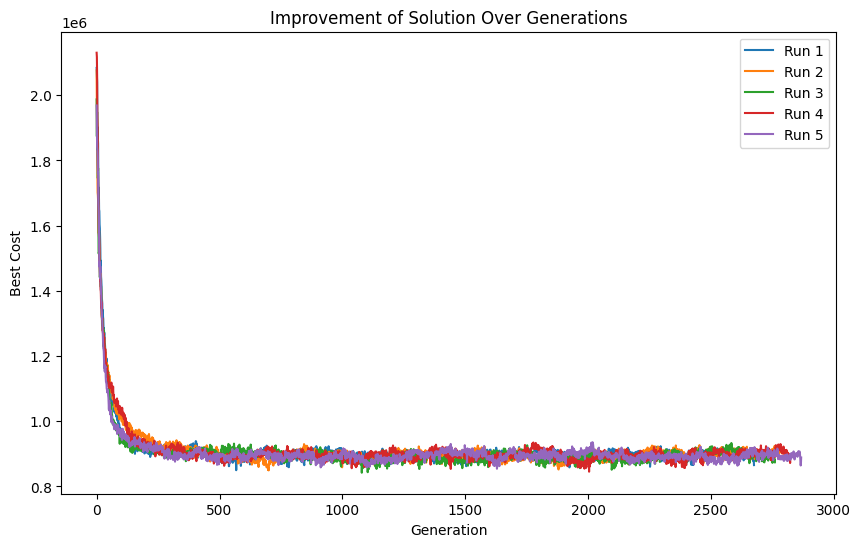

Memetic algorithm with LS1
average cost found: 822316.2699999999


Memetic algorithm with LS2
average cost found: 821948.1499999999


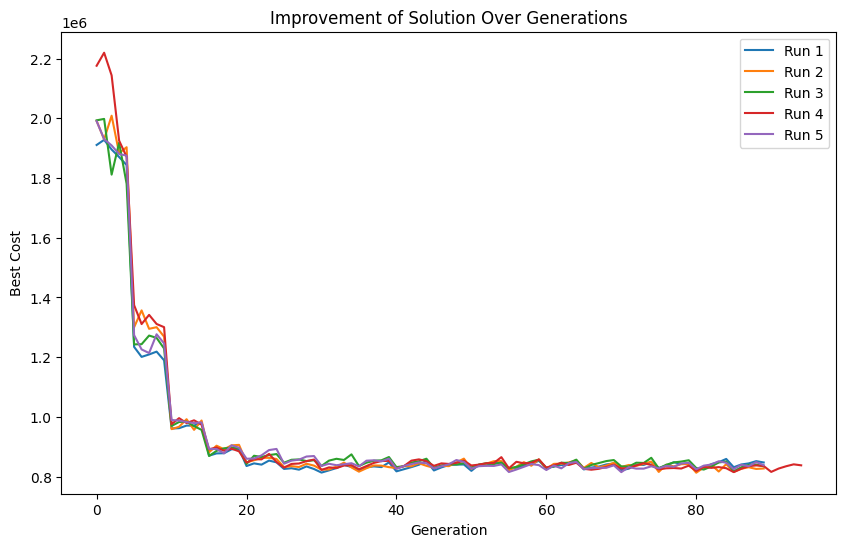

LS1 Search Average: 825243.4249999999
LS2 Search Average: 1239864.825
GA Average: 888831.2700000001
MA with LS2 Average: 822316.2699999999
MA with LS2 Average: 821948.1499999999


In [44]:
testWarehouse("warehouses\wl_50_1", 5, 50, 20, 5, 10)

File: warehouses\wl_100_4
Population size: 50
Generations: 20
Local Search Interval: 5
Max Time: 10
LS1 Search
average cost found: 208486494.351304


LS2 Search
average cost found: 83784698.84557602


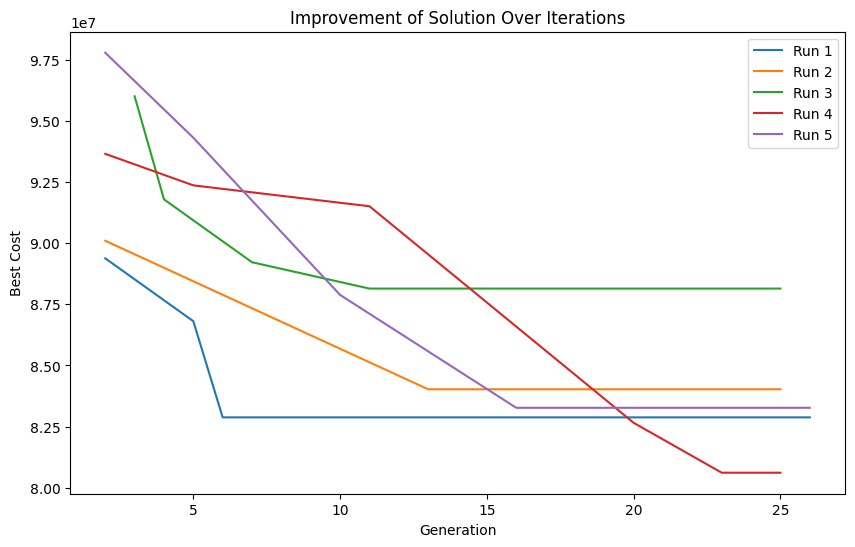

GA
average cost found: 198078450.20185202


Memetic algorithm with LS1
average cost found: 207178038.459124


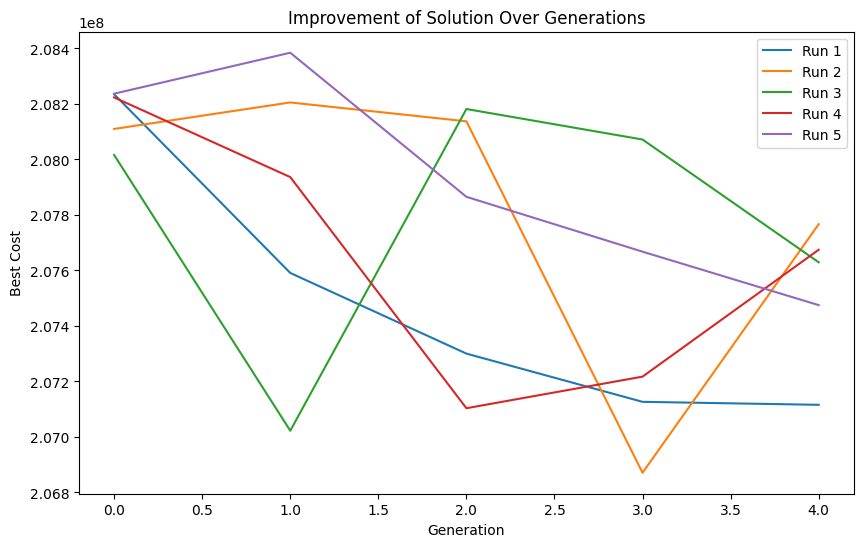

Memetic algorithm with LS2
average cost found: 90110914.73788202


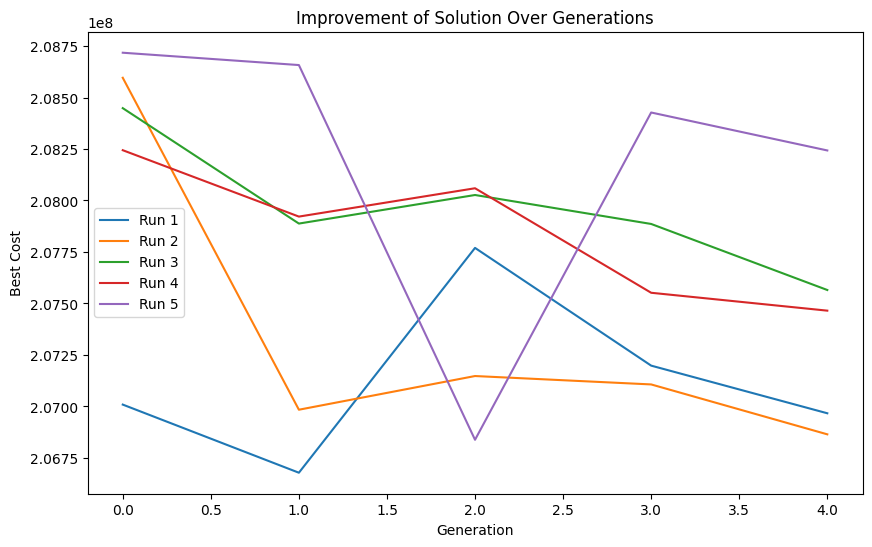

LS1 Search Average: 208561113.1647
LS2 Search Average: 83267262.65126002
GA Average: 198078450.20185202
MA with LS2 Average: 207178038.459124
MA with LS2 Average: 90110914.73788202


In [45]:
testWarehouse("warehouses\wl_100_4", 5, 50, 20, 5, 10)

# Conclusion

In my experiments with the Warehouse Allocation Problem, I observed some interesting results regarding the effectiveness of Genetic Algorithms (GA) integrated with Local Search strategies LS1 and LS2.

- **LS1 vs. LS2 Performance**: As expected, when given enough time, I found that LS1 tended to perform better, likely due to its comprehensive exploration of the solution space. However, for general use and in scenarios with time constraints, LS2 was more effective. In some cases, LS1 did not even improve single solution before time limit. Meanwhile, LS2 consistently ensured that some solution was found, making it a practical choice for situations requiring quick solutions.

- **Crossover Effectiveness**: I also have some concerns about the crossover process in my GA. I wonder if it adequately preserved positive traits from the parent solutions. Further investigation and potential refinement of the crossover mechanism could lead to even more effective solutions.

- **Potential Improvement**: A possible improvement for LS2 could be to randomly try improving positions instead of doing so in order. This change might enhance the algorithm's ability to escape local optima and explore the solution space more effectively.

In general, I have arrived at the same problem as Leo had - different models wildly varied in performance across problems, with no obvious way to distinguish optimal hyperparameters, LS, generation size and so on, before running the algorithm. For some problems, LS1 would provide optimal solutions, while for others it would be too complex to even finish single search. Memetic algorithm paired with LS2 performed reasonably well, and I expect that further modification of problem, such as adding computation time, would not significantly influence this model's effectivity - it is the most stable of the ones I have tested. However, it is possible that there is other, more generally efficient approach that neither me, not Leo have found.